# Introduction
Aim of the project is to select the best possible model to predict wheter a molecule elicit a biological response or not. The project first appeared as Kaggle [Bioresponse Competition](https://www.kaggle.com/c/bioresponse).
It is a Binary Classification problem; the target variable is `Activity`: an experimentally measured biological response to molecules in the dataset. `Activity` is `1` if there is a measured biological response, otherwise it is `0`.
Available features are 1776 Molecular Descriptors (columns `D1` - `D1776`). 

The "physical meaning" of the available Molecular Descriptors, as well as the specific Biological Response which was measured, are not made known to competition partecipants. No "domain knowledge" is applicable.

# Library Imports

In [1]:
from typing import List
from typing import Dict
from time import time
from itertools import product
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Exploratory Analysis

In [2]:
df = pd.read_csv("input/bioresponse/train.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(3751, 1777)

No missing values:

In [4]:
df.isnull().any().any()

False

In [5]:
df.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
target_name = "Activity"
y = df.loc[:, target_name]
X = df.drop(target_name, axis="columns")

Dataset is balanced:

In [7]:
y.value_counts()

1    2034
0    1717
Name: Activity, dtype: int64

In [8]:
y.mean()

0.5422553985603839

There are many input features, so it is pointless to visualize each one.
We are informed by [Data Description](https://www.kaggle.com/c/bioresponse/data) that input features are already normalized. Can we visually confirm that information, by looking at Violin Plots of Maximum, Minimum and Mean of Features? What about Variance?

In [9]:
stat_functions = ["min", "mean", "max", "var"]

stats = X.apply(stat_functions).T
stats["Descriptor"] = stats.index
stats.reset_index(inplace=True, drop=True)
stats.head()

,min,mean,max,var,Descriptor
0,0.000000,0.076948,1.000000,0.006398,D1
1,0.282128,0.592436,0.964381,0.011206,D2
2,0.000000,0.068142,0.950000,0.006149,D3
3,0.000000,0.038990,1.000000,0.013429,D4
4,0.002630,0.212112,1.000000,0.010525,D5


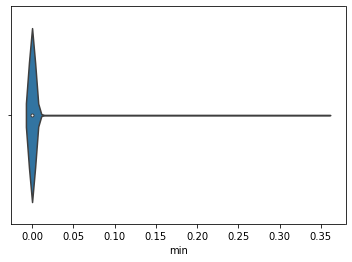

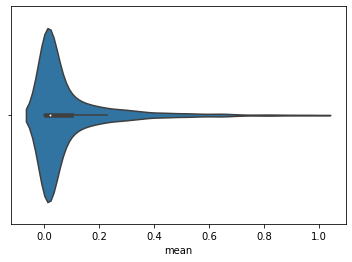

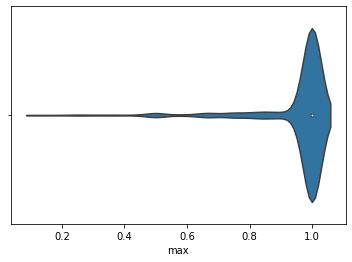

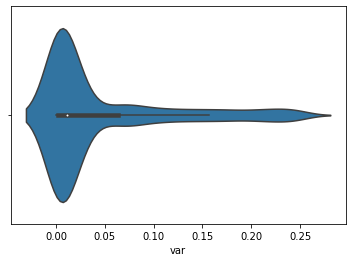

In [10]:
for fun in stat_functions:
    sns.violinplot(data=stats, x=fun)
    plt.show()

Minimum is peaked around 0, but some values are much higher.
Maximum is peaked around 1, but some values are much lower.
Mean distribution is simular to Minimum distribution, but the peak is less pronounced.


It is confirmed that Normalization, i.e. "Min-Max Scaling", was applied to the Descriptors. But predictive models may still benefit from other preliminary scaling techniques.

Variance is around 0 for most of features, but some values are higher, up to 0.3 .

Are Minimum, Maximum, Mean, and Variance, of Descriptors equally distributed between active and inactive compounds?

In [11]:
X_active = df.query(f"{target_name} == 1").drop(target_name, axis="columns")
X_inactive = df.query(f"{target_name} == 0").drop(target_name, axis="columns")

stats_active = X_active.apply(stat_functions).T
stats_active[target_name] = "active"

stats_inactive = X_inactive.apply(stat_functions).T
stats_inactive[target_name] = "inactive"

stats = pd.concat([stats_active, stats_inactive])
stats["Descriptor"] = stats.index
stats.reset_index(inplace=True, drop=True)
stats.head()

,min,mean,max,var,Activity,Descriptor
0,0.000000,0.070599,1.000000,0.005376,active,D1
1,0.358867,0.603059,0.964381,0.011100,active,D2
2,0.000000,0.080187,0.950000,0.006850,active,D3
3,0.000000,0.034292,1.000000,0.011090,active,D4
4,0.019000,0.198121,0.706597,0.009587,active,D5


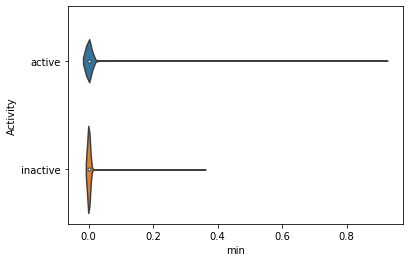

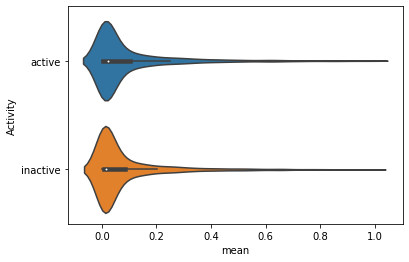

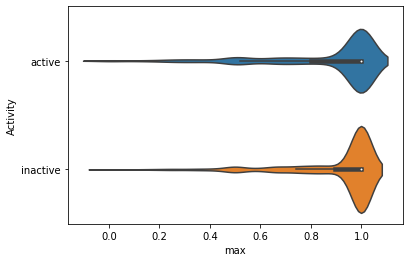

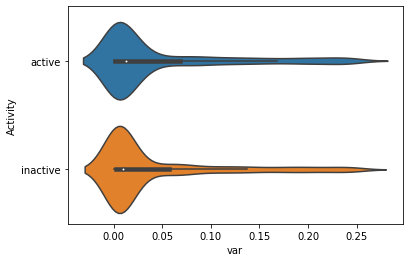

In [12]:
for fun in stat_functions:
    sns.violinplot(data=stats, x=fun, y=target_name)
    plt.show()

We can confirm that Descriptor statistics are equally distributed between active and inactive compounds.


Are the Descriptors correlated?

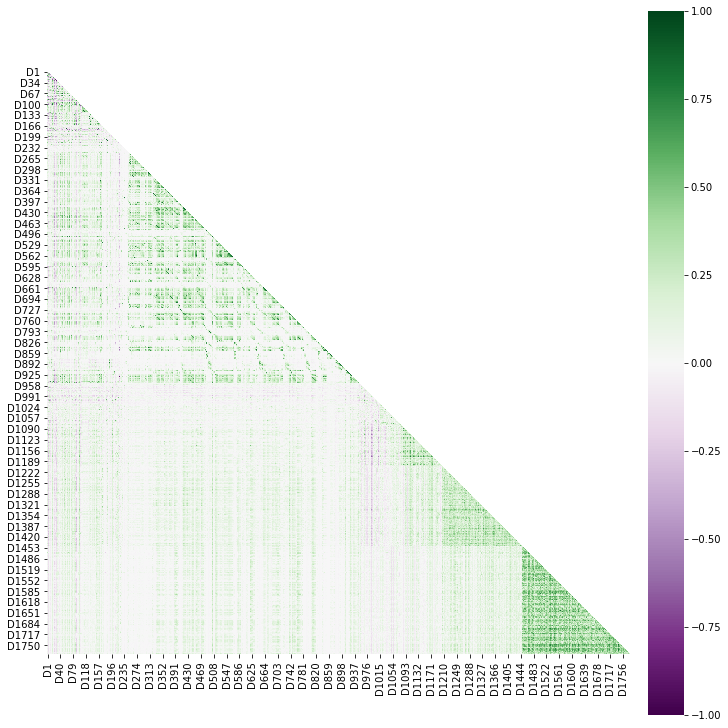

In [13]:
corr = X.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 10))
sns.heatmap(corr,
            vmin=-1,
            vmax=1,
            cmap="PRGn",
            mask=mask,
            square=True,
            ax=ax,
            );

Some features are positively correlated. A lower number of features are negatively correlated. Most features have small correlation. Still, the dataset may benefit from some kind of dimensionality reduction, such as PCA.

Try PCA without scaling:

In [14]:
pca = PCA()
pcs = pca.fit_transform(X)

pc_names = [f"PC{i}" for i in range(1, pcs.shape[1] + 1)]

pcs = pd.DataFrame(pcs, columns=pc_names)
pcs[target_name] = y.astype("category")

expl_ratios = pca.explained_variance_ratio_
expl_ratios = pd.Series(expl_ratios, index=pc_names)

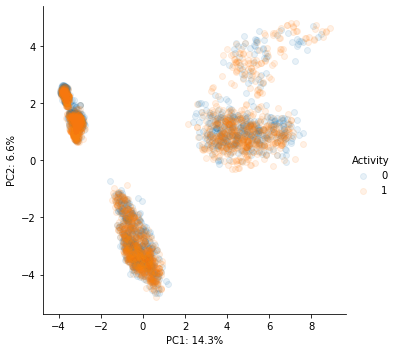

In [15]:
pc_x = 1
pc_y = 2
expl_ratio_x = expl_ratios.at[f"PC{pc_x}"]
expl_ratio_y = expl_ratios.at[f"PC{pc_y}"]

sns.lmplot(data=pcs,
           x=f"PC{pc_x}",
           y=f"PC{pc_y}",
           hue=target_name,
           fit_reg=False,
           scatter_kws={"alpha": 0.1},
           )

ax = plt.gca()
ax.set_xlabel(f"PC{pc_x}: {expl_ratio_x * 100:0.1f}%")
ax.set_ylabel(f"PC{pc_y}: {expl_ratio_y * 100:0.1f}%");

Three clusters are visible using PC1 and PC2. They do not separe active from inactive compounds.

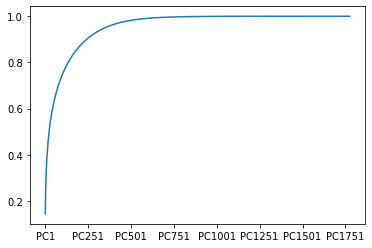

In [16]:
cumsum_expl_ratios = expl_ratios.cumsum()
cumsum_expl_ratios.plot();

In [17]:
tresholds_cumsum_expl_ratios = [0.7, 0.8, 0.9]


n_pcs_for_tresholds_unscaled = [(cumsum_expl_ratios <= tresh).argmin() + 1
                                for tresh in tresholds_cumsum_expl_ratios]

for tresh, n_pcs in zip(tresholds_cumsum_expl_ratios, n_pcs_for_tresholds_unscaled):
    print(f"{n_pcs} components are needed to have {tresh * 100}% variance")

78 components are needed to have 70.0% variance
135 components are needed to have 80.0% variance
242 components are needed to have 90.0% variance


So, without scaling, 242 components are needed to have 90% variance!

Try PCA with scaling:

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA()
pcs = pca.fit_transform(X_scaled)

pc_names = [f"PC{i}" for i in range(1, pcs.shape[1] + 1)]

pcs = pd.DataFrame(pcs, columns=pc_names)
pcs[target_name] = y.astype("category")

expl_ratios = pca.explained_variance_ratio_
expl_ratios = pd.Series(expl_ratios, index=pc_names)

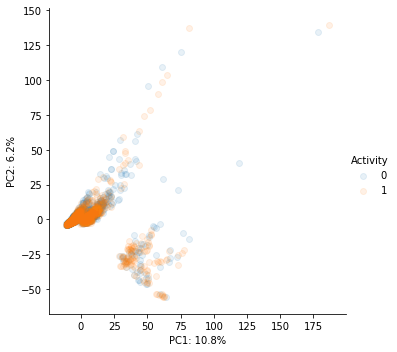

In [19]:
pc_x = 1
pc_y = 2
expl_ratio_x = expl_ratios.at[f"PC{pc_x}"]
expl_ratio_y = expl_ratios.at[f"PC{pc_y}"]

sns.lmplot(data=pcs,
           x=f"PC{pc_x}",
           y=f"PC{pc_y}",
           hue=target_name,
           fit_reg=False,
           scatter_kws={"alpha": 0.1},
           )

ax = plt.gca()
ax.set_xlabel(f"PC{pc_x}: {expl_ratio_x * 100:0.1f}%")
ax.set_ylabel(f"PC{pc_y}: {expl_ratio_y * 100:0.1f}%");

Two clusters are visible when plotting PC1 vs PC2, but they do not separe active from inactive compounds.

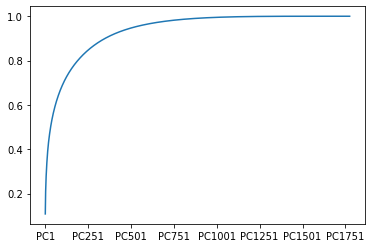

In [20]:
cumsum_expl_ratios = expl_ratios.cumsum()
cumsum_expl_ratios.plot();

In [21]:
n_pcs_for_tresholds_scaled = [(cumsum_expl_ratios <= tresh).argmin() + 1
                              for tresh in tresholds_cumsum_expl_ratios]

for tresh, n_pcs in zip(tresholds_cumsum_expl_ratios, n_pcs_for_tresholds_scaled):
    print(f"{n_pcs} components are needed to have {tresh * 100}% variance")

108 components are needed to have 70.0% variance
190 components are needed to have 80.0% variance
350 components are needed to have 90.0% variance


So, with scaling, 350 components will produce a dataset with 90% of total variance! 350 components are less than one third of total number of original features.

# Algorithm Selection
First, create train and test datasets:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1,
                                                    )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3000, 1776), (751, 1776), (3000,), (751,))

Thanks to option `stratify=y` of `train_test_split` function, both
train and test contain a balanced amount of active and inactive compounds:

In [23]:
y_train.mean(), y_test.mean()

(0.5423333333333333, 0.5419440745672437)

Let's experiment with some models before running Grid Search Cross Validation to tune hyperparameters.

First, define base hyperparameters that will be fixed in all model pipelines of each type of model:

In [24]:
kwargs_pca_unscaled = dict(n_components=n_pcs_for_tresholds_unscaled[1], random_state=1)
kwargs_pca_scaled = dict(n_components=n_pcs_for_tresholds_scaled[1], random_state=1)
kwargs_l1 = dict(penalty="l1", solver="liblinear", random_state=1)
kwargs_l2 = dict(penalty="l2", solver="liblinear", random_state=1)
kwargs_rf = dict(random_state=1)
kwargs_gb = dict(random_state=1)
kwargs_dummy = dict(strategy="stratified")

Then, define the models:

`pipelines_base_unscaled` will contain one-step pipelines: the model will be applyed on all data without preprocessing (Pipelines instead of simple estimators are used for consistency with other steps).

In [25]:
#models applied on all data, without preprocessing.
pipelines_base_unscaled = {"l1": make_pipeline(LogisticRegression(**kwargs_l1)),
                           "l2": make_pipeline(LogisticRegression(**kwargs_l2)),
                           "rf": make_pipeline(RandomForestClassifier(**kwargs_rf)),
                           "gb": make_pipeline(GradientBoostingClassifier(**kwargs_gb)),
                           "dummy": make_pipeline(DummyClassifier(**kwargs_dummy))
                           }


#Then, create all the other models.
#In order to avoid boilerplate code as much as possible,
#two helper functions will be defined, that insert new preprocessing steps
#to existing pipelines dictionary, and rename the models contained in each pipelines dictionary
#adding info about the preprocessing steps

def add_identifier_to_names_pipelines_dict(pipelines: Dict, identifier: str=None):
    
    if not (isinstance(pipelines, Dict) and any(pipelines)):
        raise ValueError("First argument should be a non-empty dictionary!")
    
    
    old_names = list(pipelines.keys()) #(!)otherwise, each key will be changed twice!
    for old_name in old_names:
        new_name = f"{old_name}_{identifier}"
        pipelines[new_name] = pipelines.pop(old_name) #inplace!
        
    
    return None
            
            
def insert_steps_to_pipelines_dict(steps: List,
                                   pipelines: Dict,
                                   identifier: str = None,
                                   ):
    
    if not (isinstance(steps, List) and any(steps)):
        raise ValueError("First argument should be a non-empty list!")
    elif not (isinstance(pipelines, Dict) and any(pipelines)):
        raise ValueError("Second argument should be a non-empty dictionary!")
    
    
    new_pipelines = {name: clone(pipeline)
                     for name, pipeline in pipelines.items()}
    
    reverse_steps = steps.copy()
    reverse_steps.reverse() #remember, list.reverse() is inplace!
    for step, new_pipeline in product(reverse_steps, new_pipelines.values()):
        new_pipeline.steps.insert(0, step)
    
    
    if identifier:
        add_identifier_to_names_pipelines_dict(new_pipelines, identifier) #this step is inplace
    
    
    return new_pipelines


#Use the defined functions to create the new pipelines
pipelines_base_scaled = insert_steps_to_pipelines_dict([("standardscaler", StandardScaler())],
                                                       pipelines_base_unscaled,
                                                       identifier="base_scaled",
                                                       )
pipelines_pca_unscaled = insert_steps_to_pipelines_dict([("pca", PCA(**kwargs_pca_unscaled))],
                                                        pipelines_base_unscaled,
                                                        identifier="pca_unscaled",
                                                        )
pipelines_pca_scaled = insert_steps_to_pipelines_dict([("standardscaler", StandardScaler()), ("pca", PCA(**kwargs_pca_scaled))],
                                                      pipelines_base_unscaled,
                                                      identifier="pca_scaled",
                                                      )

#add identifier also to model names of base unscaled pipelines
add_identifier_to_names_pipelines_dict(pipelines_base_unscaled, "base_unscaled")

#merge all pipelines dictionary
pipelines_all = {**pipelines_base_unscaled, **pipelines_base_scaled, **pipelines_pca_unscaled, **pipelines_pca_scaled}

In [26]:
fitted_models_all = {}
times_all = []
for name, model in pipelines_all.items():
    
    start_time = time()
    
    model.fit(X_train, y_train)
    
    end_time = time()
    tot_time = end_time - start_time
    times_all.append(tot_time)
    print(f"{name} has been fitted in {tot_time / 3600:0.6f} hours!")
    
    fitted_models_all.update({name: model})

l1_base_unscaled has been fitted in 0.000204 hours!
l2_base_unscaled has been fitted in 0.000129 hours!
rf_base_unscaled has been fitted in 0.000381 hours!
gb_base_unscaled has been fitted in 0.003600 hours!
dummy_base_unscaled has been fitted in 0.000000 hours!
l1_base_scaled has been fitted in 0.001863 hours!
l2_base_scaled has been fitted in 0.002087 hours!
rf_base_scaled has been fitted in 0.000408 hours!
gb_base_scaled has been fitted in 0.004113 hours!
dummy_base_scaled has been fitted in 0.000031 hours!
l1_pca_unscaled has been fitted in 0.000154 hours!
l2_pca_unscaled has been fitted in 0.000174 hours!
rf_pca_unscaled has been fitted in 0.000664 hours!
gb_pca_unscaled has been fitted in 0.002793 hours!
dummy_pca_unscaled has been fitted in 0.000133 hours!
l1_pca_scaled has been fitted in 0.000193 hours!
l2_pca_scaled has been fitted in 0.000209 hours!
rf_pca_scaled has been fitted in 0.000731 hours!
gb_pca_scaled has been fitted in 0.003804 hours!
dummy_pca_scaled has been fitt

Calculate various scoring metrics on training an test set, and rank the scores:

In [27]:
df_results_all = []
for name, model in fitted_models_all.items():
    
    accuracy_score = model.score(X_train, y_train)
    
    pred_proba = model.predict_proba(X_test)[:, 1]
    
    auroc = roc_auc_score(y_test, pred_proba)
    neg_loss = log_loss(y_test, pred_proba)
    
    tmp = {"model": name,
           "accuracy_train": accuracy_score,
           "auroc_test": auroc,
           "neg_log_loss_test": neg_loss,
           }
    df_results_all.append(tmp)

df_results_all = pd.DataFrame(df_results_all)

#add time column
df_results_all["time"] = times_all

#Rank each score results
for score_name in ["accuracy_train", "auroc_test", "neg_log_loss_test"]:
    ascending = score_name == "neg_log_loss_test"
    df_results_all[f"rank_{score_name}"] = df_results_all[score_name].rank(ascending=ascending)

#Add a mean rank column, and sort values based on it
mask_rank_columns = df_results_all.columns.str.startswith("rank")
df_results_all["mean_rank"] = df_results_all.loc[:, mask_rank_columns].mean(axis="columns")
df_results_all.sort_values("mean_rank", inplace=True, ignore_index=True)

df_results_all

,model,accuracy_train,auroc_test,neg_log_loss_test,time,rank_accuracy_train,rank_auroc_test,rank_neg_log_loss_test,mean_rank
0,rf_base_unscaled,1.000000,0.865611,0.466575,1.373078,1.5,1.0,3.0,1.833333
1,rf_base_scaled,1.000000,0.865465,0.466952,1.470094,1.5,2.0,4.0,2.500000
2,gb_base_scaled,0.858667,0.861586,0.465861,14.807796,10.5,3.5,1.5,5.166667
3,gb_base_unscaled,0.858667,0.861586,0.465861,12.960206,10.5,3.5,1.5,5.166667
4,rf_pca_scaled,0.999333,0.838713,0.516240,2.630365,4.0,6.0,6.0,5.333333
5,gb_pca_scaled,0.897667,0.840781,0.496496,13.693141,7.0,5.0,5.0,5.666667
6,rf_pca_unscaled,0.999667,0.830153,0.525519,2.391025,3.0,9.0,9.0,7.000000
7,gb_pca_unscaled,0.889000,0.822810,0.518632,10.054775,8.0,11.0,7.0,8.666667
8,l2_pca_scaled,0.790000,0.830774,0.536002,0.751201,13.0,7.0,12.0,10.666667
9,l1_pca_scaled,0.788667,0.830767,0.532904,0.693453,14.0,8.0,11.0,11.000000


Results are quite interesting! No model is the best for accuracy score on training data and for AUROC and negative Log Loss on test data.
As expected, Random Forest and Gradient Boosting perform better than Logistic Regression with L1 or L2 regularization.

All preprocessing techniques (StandardScaling and PCA) do not improve the results for Random Forest and Gradient Boosting. So, it is confirmed that the features were already successfully normalized, and that the algorithms built-in feature selection is very effective.

So, hyperparameter tuning with Cross Validation will be performed on the bare models, without any preprocessing steps.

# Final Models Training with Hyperparameter Tuning:

Define hyperparameter grids:

In [28]:
grid_l1 = {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 1500]}
grid_l2 = grid_l1
grid_rf = {"n_estimators": [100, 200],
           "max_features": ["auto", "sqrt", 0.33],
           "min_samples_leaf": [1, 2, 3, 5, 10],
           }
grid_gb = {"n_estimators": [100, 200],
           "learning_rate": [0.03, 0.05, 0.1, 0.2],
           "max_depth": [1, 2, 3, 5, None],
           }
grid_dummy = {}

hyperparameters = {"l1": grid_l1,
                   "l2": grid_l2,
                   "rf": grid_rf,
                   "gb": grid_gb,
                   "dummy": grid_dummy,
                   }

Define all models:

In [29]:
models = {"l1": LogisticRegression(**kwargs_l1),
          "l2": LogisticRegression(**kwargs_l2),
          "rf": RandomForestClassifier(**kwargs_rf),
          "gb": GradientBoostingClassifier(**kwargs_gb),
          "dummy": DummyClassifier(**kwargs_dummy),
          }

Fit all models:

In [30]:
fitted_models_cv = {}
times_cv = []
for name, model in models.items():
    
    start_time = time()
    
    #Insert model in GridSearchCV
    model_cv = GridSearchCV(estimator=model,
                            param_grid=hyperparameters.get(name),
                            n_jobs=2,
                            )
    #fit model performing CV
    model_cv.fit(X_train, y_train)
    
    end_time = time()
    tot_time = end_time - start_time
    times_cv.append(tot_time)
    print(f"{name} has been fitted in {tot_time / 3600:0.6f} hours!")
    
    fitted_models_cv.update({name: model_cv})

l1 has been fitted in 0.120976 hours!
l2 has been fitted in 0.017845 hours!
rf has been fitted in 0.150594 hours!
gb has been fitted in 0.727637 hours!
dummy has been fitted in 0.000024 hours!


Calculate various scoring metrics on training set and test set:

In [31]:
df_results_cv = []
for name, model in fitted_models_cv.items():
    
    accuracy_score = model.score(X_train, y_train)
    
    pred_proba = model.predict_proba(X_test)[:, 1]
    
    auroc = roc_auc_score(y_test, pred_proba)
    neg_loss = log_loss(y_test, pred_proba)
    
    tmp = {"model": name,
           "accuracy_train": accuracy_score,
           "auroc_test": auroc,
           "neg_log_loss_test": neg_loss,
           }
    df_results_cv.append(tmp)

df_results_cv = pd.DataFrame(df_results_cv)

#add time column
df_results_cv["time"] = times_cv

#Rank each score results
for score_name in ["accuracy_train", "auroc_test", "neg_log_loss_test"]:
    ascending = score_name == "neg_log_loss_test"
    df_results_cv[f"rank_{score_name}"] = df_results_cv[score_name].rank(ascending=ascending)

#Add a mean rank column, and sort values based on it
mask_rank_columns = df_results_cv.columns.str.startswith("rank")
df_results_cv["mean_rank"] = df_results_cv.loc[:, mask_rank_columns].mean(axis="columns")
df_results_cv.sort_values("mean_rank", inplace=True, ignore_index=True)

df_results_cv

,model,accuracy_train,auroc_test,neg_log_loss_test,time,rank_accuracy_train,rank_auroc_test,rank_neg_log_loss_test,mean_rank
0,gb,1.000000,0.873600,0.495380,2619.491462,1.0,1.0,2.0,1.333333
1,rf,0.995333,0.872382,0.445357,542.136666,2.0,2.0,1.0,1.666667
2,l2,0.819667,0.832938,0.498893,64.241842,3.0,3.0,3.0,3.000000
3,l1,0.779333,0.819717,0.517842,435.511946,4.0,4.0,4.0,4.000000
4,dummy,0.503000,0.495890,17.246598,0.085766,5.0,5.0,5.0,5.000000


As expected, Random Forest and Gradient Boosting are the two best algorithms.

For Random Forest, AUROC and Log Loss scores calculated on test set improved after hyperparameter tuning.

For Gradient Boosting, AUROC improved a bit after hyperparameter tuning, but Log Loss got worse.

Considering that Log Loss will be used to score results for the contest, Random Forest is, in my opinion, the best model.
Its training time is also competitive, being almost five times lower than training time required for Gradient Boosting.

Simpler model Logistic Regression, with L1 and L2 regularization, still gave reasonable results, which are much better than a Dummy estimator.

Save all best models obtained after hyperparameter tuning with GridSearchCV:

In [32]:
for name, model in fitted_models_cv.items():
    
    if name != "dummy":
        
        out_name = f"output/best_{name}_model.pickle"
        
        with open(out_name, "wb") as f:
            pickle.dump(model.best_estimator_, f)
    
    else:
        pass

# Analysis of Final Models

In [56]:
l1 = fitted_models_cv.get("l1").best_estimator_
l2 = fitted_models_cv.get("l2").best_estimator_
rf = fitted_models_cv.get("rf").best_estimator_
gb = fitted_models_cv.get("gb").best_estimator_

### Analysis of L1

Observe distribution of coefficients:

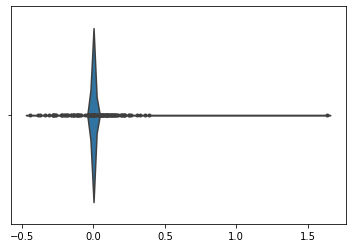

In [34]:
feature_names = X.columns

coef_l1 = l1.coef_.reshape(-1)
coef_l1 = pd.Series(coef_l1, index=feature_names)

sns.violinplot(coef_l1, inner="point");

Most coefficients have values around zero, a large quantity is between -0.5 and 0.5, one is larger than 1.5.

How many coefficients are exactly 0, and thus did not take part in the final model? How many coefficients are not zero?

In [49]:
n_coef_l1_zero = (coef_l1 == 0).sum()
n_coef_l1_notzero = (coef_l1 != 0).sum()
n_features = feature_names.shape[0]
frac_coef_l1_notzero = n_coef_l1_notzero / n_features

print(f"{frac_coef_l1_notzero * 100:0.1f}% of features have a non-zero coefficient!")

6.1% of features have a non-zero coefficient!


Get the coefficients sorted by their absolute values, in order to know what features are more important:

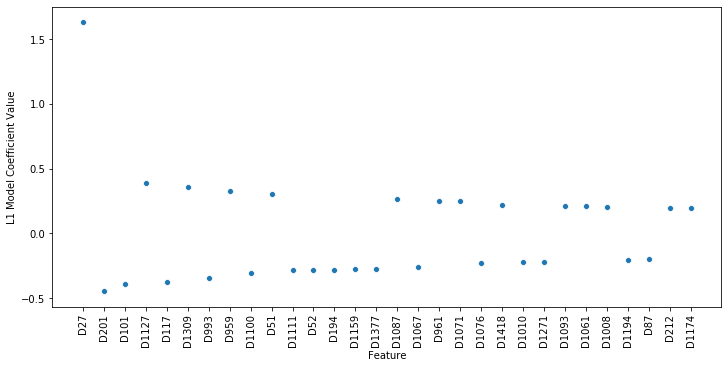

In [36]:
most_important_features_l1 = coef_l1[coef_l1 != 0].abs().sort_values(ascending=False).index
coef_l1_abs_sorted = coef_l1[most_important_features_l1]

n_show_most_important_features_l1 = 30
fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 5))
sns.scatterplot(data=coef_l1_abs_sorted.head(n_show_most_important_features_l1), ax=ax)
ax.tick_params(axis="x", labelrotation=90) #vertical xtick labels
ax.set_xlabel("Feature")
ax.set_ylabel("L1 Model Coefficient Value");

### Analysis of L2:

Observe distribution of coefficients:

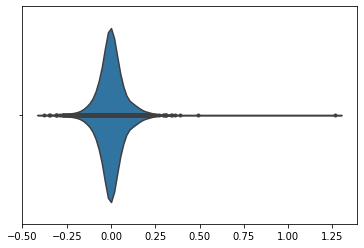

In [37]:
coef_l2 = l2.coef_.reshape(-1)
coef_l2 = pd.Series(coef_l2, index=feature_names)

sns.violinplot(coef_l2, inner="point");

The distribution of coefficients for L2 model is centered around 0, but larger than L1 model coefficient distribution. Most coefficients range from -0.5 and 0.5, the largest is more than 1.25 .

How many coefficients are exactly 0, and thus did not take part in the final model? How many coefficients are not zero?

In [38]:
n_coef_l2_zero = (coef_l2 == 0).sum()
n_coef_l2_zero

0

So, with L2 regularization, as expected, no coefficients have exactly value 0, but many coefficients have very small values.

Get the coefficients sorted by their absolute values, in order to know which features are more important:

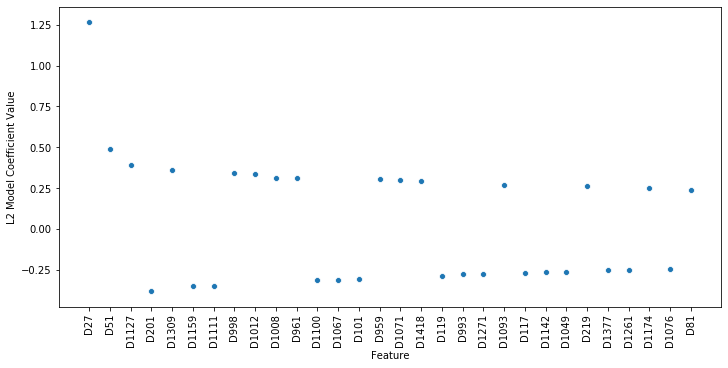

In [39]:
most_important_features_l2 = coef_l2.abs().sort_values(ascending=False).index
coef_l2_abs_sorted = coef_l2[most_important_features_l2]

n_show_most_important_features_l2 = 30
fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 5))
sns.scatterplot(data=coef_l2_abs_sorted.head(n_show_most_important_features_l2), ax=ax)
ax.tick_params(axis="x", labelrotation=90) #vertical xtick labels
ax.set_xlabel("Feature")
ax.set_ylabel("L2 Model Coefficient Value");

Compare the coefficients of L1 and L2 Logistic regression models:

In [40]:
df_coef_l1_l2 = pd.DataFrame({"coef_l1": coef_l1, "coef_l2": coef_l2}, index=feature_names)
df_coef_l1_l2.index.name = "Feature"
for coef in df_coef_l1_l2.columns:
    df_coef_l1_l2[f"abs_{coef}"] = df_coef_l1_l2[coef].abs()
    df_coef_l1_l2[f"rank_abs_{coef}"] = df_coef_l1_l2[f"abs_{coef}"].rank(ascending=False)

#Add a mean rank column, and sort values based on it
mask_rank_columns = df_coef_l1_l2.columns.str.startswith("rank")
df_coef_l1_l2["mean_rank"] = df_coef_l1_l2.loc[:, mask_rank_columns].mean(axis="columns")
df_coef_l1_l2.sort_values("mean_rank", inplace=True)

df_coef_l1_l2.head(10)

,coef_l1,coef_l2,abs_coef_l1,rank_abs_coef_l1,abs_coef_l2,rank_abs_coef_l2,mean_rank
Feature,,,,,,,
D27,1.632336,1.263974,1.632336,1.0,1.263974,1.0,1.0
D201,-0.446585,-0.378625,0.446585,2.0,0.378625,4.0,3.0
D1127,0.386733,0.390294,0.386733,4.0,0.390294,3.0,3.5
D1309,0.360053,0.360573,0.360053,6.0,0.360573,5.0,5.5
D51,0.305171,0.490817,0.305171,10.0,0.490817,2.0,6.0
D101,-0.389270,-0.307126,0.389270,3.0,0.307126,14.0,8.5
D1111,-0.284294,-0.345905,0.284294,11.0,0.345905,7.0,9.0
D1159,-0.276286,-0.350795,0.276286,14.0,0.350795,6.0,10.0
D1100,-0.308159,-0.310995,0.308159,9.0,0.310995,12.0,10.5


Feature `D27` is the most important for both L1 and L2 models. Many other features are considered important by both models.

### Analysis of Random Forest

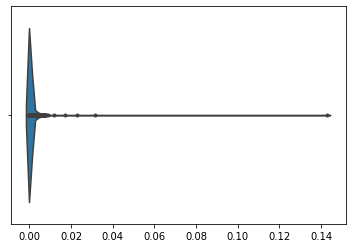

In [43]:
importances_rf = rf.feature_importances_
importances_rf = pd.Series(importances_rf, index=feature_names)

sns.violinplot(importances_rf, inner="point");

Most features have an importance zero. The most important feature is around 0.14 .

How many feature importances are exactly zero? How many are not zero?

In [51]:
n_importances_rf_zero = (importances_rf == 0).sum()
n_importances_rf_notzero = (importances_rf != 0).sum()
frac_importances_rf_notzero = n_importances_rf_notzero / n_features

print(f"{frac_importances_rf_notzero * 100:0.1f}% of features have a non-zero importance!")

76.0% of features have a non-zero importance!


For L1 model, very few features had non-zero coefficients, whereas for Random Forest most of the features have non-zero importance.

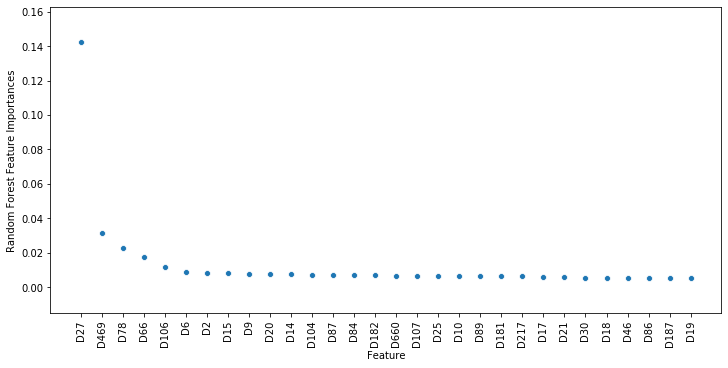

In [54]:
most_important_features_rf = importances_rf[importances_rf != 0].sort_values(ascending=False).index
importances_rf_sorted = importances_rf[most_important_features_rf]

n_show_most_important_features_rf = 30
fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 5))
sns.scatterplot(data=importances_rf_sorted.head(n_show_most_important_features_rf), ax=ax)
ax.tick_params(axis="x", labelrotation=90) #vertical xtick labels
ax.set_xlabel("Feature")
ax.set_ylabel("Random Forest Feature Importances");

### Analysis of Gradient Boosting

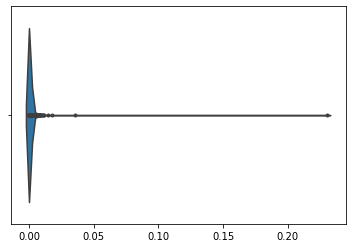

In [57]:
importances_gb = gb.feature_importances_
importances_gb = pd.Series(importances_gb, index=feature_names)

sns.violinplot(importances_gb, inner="point");

The distribution of feature importances for Gradient Boosting is very similar to that of Random Forest, but the most important feature has an higher importance.

How many feature importances are exactly zero? How many are not zero?

In [58]:
n_importances_gb_zero = (importances_gb == 0).sum()
n_importances_gb_notzero = (importances_gb != 0).sum()
frac_importances_gb_notzero = n_importances_gb_notzero / n_features

print(f"{frac_importances_gb_notzero * 100:0.1f}% of features have a non-zero importance!")

47.1% of features have a non-zero importance!


For Gradient Boosting, fewer features than Random Forest have non-zero importance.

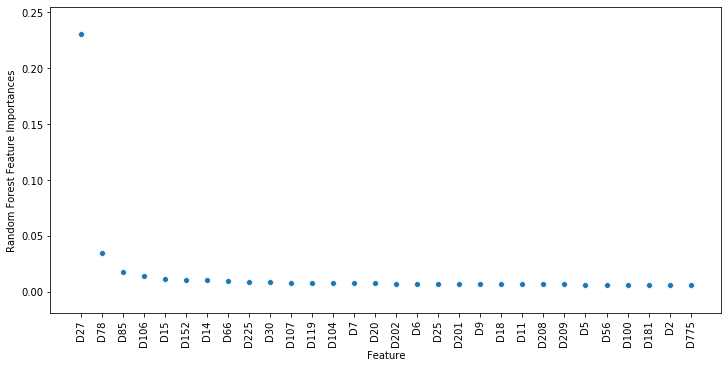

In [59]:
most_important_features_gb = importances_gb[importances_gb != 0].sort_values(ascending=False).index
importances_gb_sorted = importances_gb[most_important_features_gb]

n_show_most_important_features_gb = 30
fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 5))
sns.scatterplot(data=importances_gb_sorted.head(n_show_most_important_features_gb), ax=ax)
ax.tick_params(axis="x", labelrotation=90) #vertical xtick labels
ax.set_xlabel("Feature")
ax.set_ylabel("Random Forest Feature Importances");

Compare the feature importances of Random Forest and Gradient Boosting:

In [63]:
df_importance_rf_gb = pd.DataFrame({"importance_rf": importances_rf, "importance_gb": importances_gb}, index=feature_names)
df_importance_rf_gb.index.name = "Feature"
for imp in df_importance_rf_gb.columns:
    df_importance_rf_gb[f"rank_{imp}"] = df_importance_rf_gb[imp].rank(ascending=False)

#Add a mean rank column, and sort values based on it
mask_rank_columns = df_importance_rf_gb.columns.str.startswith("rank")
df_importance_rf_gb["mean_rank"] = df_importance_rf_gb.loc[:, mask_rank_columns].mean(axis="columns")
df_importance_rf_gb.sort_values("mean_rank", inplace=True)

df_importance_rf_gb.head(10)

,importance_rf,importance_gb,rank_importance_rf,rank_importance_gb,mean_rank
Feature,,,,,
D27,0.142719,0.230460,1.0,1.0,1.0
D78,0.022764,0.035320,3.0,2.0,2.5
D106,0.011753,0.014431,5.0,4.0,4.5
D66,0.017315,0.009564,4.0,8.0,6.0
D15,0.007988,0.011395,8.0,5.0,6.5
D14,0.007342,0.010402,11.0,7.0,9.0
D6,0.008857,0.007269,6.0,17.0,11.5
D104,0.007232,0.008055,12.0,13.0,12.5
D20,0.007379,0.007642,10.0,15.0,12.5


`D27` is the most important feature for all considered models.

Many other important features are shared between Random Forest and Gradient Boosting, whereas most important features for Random Forest and Gradient Boosting are not necessarily that important for L1 and L2 Logistic Regression models.

# Results Submission

In [65]:
X_blind = pd.read_csv("input/bioresponse/test.csv")
X_blind.shape

(2501, 1776)

In [66]:
X_blind.shape[1] == n_features

True

In [68]:
example_submission = pd.read_csv("input/bioresponse/svm_benchmark.csv")
example_submission.columns

Index(['MoleculeId', 'PredictedProbability'], dtype='object')

In [71]:
for name, model in {"rf": rf, "gb": gb, "l1": l1, "l2": l2}.items():
    
    pred_proba = model.predict_proba(X_blind)[:, 1]
    df_submission = pd.DataFrame({"MoleculeId": example_submission["MoleculeId"], "PredictedProbability": pred_proba})
    
    submission_name = f"output/pred_proba_{name}.csv"
    df_submission.to_csv(submission_name, index=False)

After manually submitting all my predictions, I got the following Log Loss [results](https://www.kaggle.com/c/bioresponse/leaderboard):

Random Forest: 0.45960

Gradient Boosting: 0.49793

L1 Logistic Regression: 0.54131

L2 Logistic Regression: 0.53428

Random Forest and Gradient Boosting had a comparable Log Loss performance on the blind unlabeled dataset and on the test dataset. The predictions made by L1 and L2 models on blind set are worse than predictions made on test set.

My models did not win the competition. But I think that Random Forest and Gradient Boosting are very promising for this dataset, and given more computational time, I think that it would be possible to obtain better results by tuning more hyperparameters!